# Decision Tree Implementation

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 

data = load_breast_cancer()

print(data.keys())
X = data["data"]
y = data["target"]

assert len(X) == len(y), "target label size does not match"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


MAX_DEPTH = 3

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
(455, 30) (114, 30) (455,) (114,)


## reference baseline

[1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0
 1 1 0]


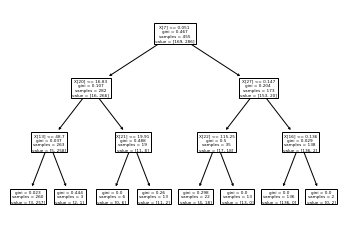

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


clf = DecisionTreeClassifier(max_depth = MAX_DEPTH)

tree.plot_tree(clf.fit(X_train, y_train))


baseline = clf.predict(X_test)

print(baseline)


## Implementation

In [18]:
import numpy as np


class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        
        
class DecisionTree:
    def __init__(self, max_depth = None):
        self._max_depth = max_depth
    
    def fit(self, X, y):
        self.num_classes = len(set(y))
        self.num_features = X.shape[1]
        self.tree = self._grow_tree(X, y)
    
    def _calculate_gini(self, y):
        """Compute Gini impurity of a non-empty node.
        Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
        class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
        """
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.num_classes))
    
    
    def _calculate_split(self, X, y):
        m = len(y)
        if m <= 1:
            return None, None
        
        num_parent = [np.sum(y == c) for c in range(self.num_classes)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        
        for idx in range(self.num_features):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            
            num_left = [0] * self.num_classes
            num_right = num_parent.copy()
            
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.num_classes))
                
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.num_classes))
        
                gini = (i * gini_left + (m - i) * gini_right) / m
                
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2 
        
        return best_idx, best_thr
    
    
    def _grow_tree(self, X, y, depth = 0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        
        node = Node(
            gini=self._calculate_gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )
        
        if depth < self._max_depth:
            idx, thr = self._calculate_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth = depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth = depth + 1)
                
        return node
    

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
        
                
                
    
        
        
    
decision_tree = DecisionTree(max_depth = MAX_DEPTH)    
decision_tree.fit(X_train, y_train)
result = decision_tree.predict(X_test)


print("baseline\n", list(baseline))
print("result\n", list(result))
#assert list(baseline) == list(result), "the result is different from the baseline"

for i, v in enumerate(zip(list(result), list(baseline))):
    if v[0] != v[1]:
        print(f"the {i} element is different: {v[0]}, {v[1]}")
    
    

baseline
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
result
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0]
the 32 element is different: 0, 1
